# **Preprocess the dataset and stores tensors to Google Driver**

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
path = os.path.join('/content/drive/MyDrive/')

Mounted at /content/drive


##**Read data files** ##

Read dataframes from csv files

In [2]:
import pandas as pd
import os

path = '/content/drive/MyDrive'
train_file = os.path.join(path, 'combined_train.csv')
val_file = os.path.join(path, 'combined_val.csv')
test_file = os.path.join(path, 'combined_test.csv')

train_df = pd.read_csv(train_file)
val_df = pd.read_csv(val_file)
test_df = pd.read_csv(test_file)

Read train, validation, test data

In [3]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.4 MB/s eta 0:00:00


Load pretrained ViLT model

In [4]:
from transformers import ViltProcessor, ViltForQuestionAnswering
import torch

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

Preprocess the images and comments to encodings and stores them to the storage

##**Finetune the ViLT model** ##

create dataloaders

In [5]:
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision.transforms import Resize
import torchvision
import numpy as np

class ViltDataset(Dataset):
  def __init__(self, dataframes):
    self.base_path = '/content/drive/MyDrive'
    self.img_paths = dataframes['filename']
    self.comments = dataframes['clean_comments']
    self.resize = Resize((384, 512))
    self.labels = dataframes['scenic']

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    img = self.resize(read_image(os.path.join(self.base_path, img_path), mode=torchvision.io.ImageReadMode.RGB))
    comment = self.comments[idx]
    encoding = processor(img, comment, return_tensors='pt', padding='max_length', truncation=True)
    label = torch.nn.functional.one_hot(torch.tensor(self.labels[idx]), num_classes=2)

    return [encoding, label]

In [6]:
# create dataloaders
training_data = ViltDataset(train_df[:])
test_data = ViltDataset(test_df[:])
val_data = ViltDataset(val_df[:])

In [7]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=10, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=10, shuffle=True)

Define a classifier model

In [8]:
class ScenicClassifier(torch.nn.Module):
  def __init__(self, enc_features: int):
    super().__init__()
    self.embedding = model.vilt
    self.classifier = torch.nn.Sequential(
        torch.nn.Linear(enc_features, 32, bias=False),
        # torch.nn.ReLU(),
        # torch.nn.Linear(64, 16, bias=False),
        torch.nn.Linear(32, 2, bias=False),
        # torch.nn.ReLU()
        )

  def forward(self, encodings):
    embeds = self.embedding(**encodings)['pooler_output']
    logits = self.classifier(embeds)

    return logits

In [9]:
class ScenicClassifier2(torch.nn.Module):
  def __init__(self, enc_features: int):
    super().__init__()
    self.embedding = model.vilt
    self.classifier = torch.nn.Linear(enc_features, 2, bias=False)
    torch.nn.init.xavier_uniform(self.classifier.weight)

  def forward(self, encodings):
    embeds = self.embedding(**encodings)['pooler_output']
    logits = self.classifier(embeds)

    return logits

In [10]:
device='cuda:0'
# device='cpu'
classifier = ScenicClassifier(768)
# classifier = ScenicClassifier2(768)
classifier.to(device)

criterion = torch.nn.MSELoss()
criterion.to(device)
# optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.001, momentum=0.8)

## Train the model

In [11]:
classifier.train()
loss_log = []
epoch_loss = 0.0
for epoch in range(2):
  running_loss = 0.0
  epoch_loss_log = []
  for i, data in enumerate(train_dataloader, 0):
    encodings, labels = data
    encodings.to(device)
    labels.to(device)
    for key in encodings.keys():
      encodings[key] = torch.squeeze(encodings[key], 1)
    optimizer.zero_grad()
    outputs = classifier(encodings)
    labels = torch.tensor(labels, dtype=torch.float).cuda()
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if i % 10 == 9:
      print(f'[{epoch+1}, {i+1:5d}] loss : {running_loss / 10:.3f}')
      epoch_loss = running_loss / 10.0
      epoch_loss_log.append(epoch_loss)
      running_loss=0.0

  loss_log.append(epoch_loss_log)

print('Finished training')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
<ipython-input-11-b81db43217f6>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float).cu

[1,    10] loss : 0.366
[1,    20] loss : 0.257
[1,    30] loss : 0.226
[1,    40] loss : 0.205
[1,    50] loss : 0.187
[1,    60] loss : 0.176
[1,    70] loss : 0.155
[1,    80] loss : 0.147
[1,    90] loss : 0.129
[1,   100] loss : 0.128
[1,   110] loss : 0.136
[1,   120] loss : 0.127
[1,   130] loss : 0.116
[1,   140] loss : 0.117
[1,   150] loss : 0.127
[1,   160] loss : 0.103
[1,   170] loss : 0.112
[1,   180] loss : 0.122
[1,   190] loss : 0.104
[1,   200] loss : 0.104
[1,   210] loss : 0.121
[1,   220] loss : 0.101
[1,   230] loss : 0.083
[1,   240] loss : 0.118
[1,   250] loss : 0.097
[2,    10] loss : 0.116
[2,    20] loss : 0.089
[2,    30] loss : 0.104
[2,    40] loss : 0.082
[2,    50] loss : 0.089
[2,    60] loss : 0.085
[2,    70] loss : 0.087
[2,    80] loss : 0.083
[2,    90] loss : 0.076
[2,   100] loss : 0.084
[2,   110] loss : 0.088
[2,   120] loss : 0.078
[2,   130] loss : 0.073
[2,   140] loss : 0.079
[2,   150] loss : 0.086
[2,   160] loss : 0.086
[2,   170] loss 

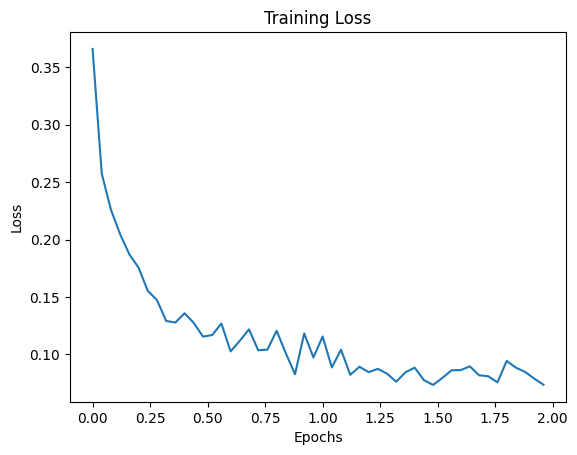

In [12]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

x_ = np.arange(0, len(loss_log), 1.0/len(loss_log[0]))
y_ = np.reshape(np.array(loss_log), -1)
plt.plot(x_, y_)

Store the finetuned model to the Google drive

In [13]:
model_path = '/content/drive/MyDrive/scenic_model_bilal_new.pt'
torch.save(classifier.state_dict(), model_path)

## Test the result

In [14]:
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

device = 'cuda:0'

def f1_score_eval(dataloader, dataname):
  correct = 0
  total = 0
  predicts = torch.zeros(0)
  groundtruth = torch.zeros(0)
  with torch.no_grad():
    for testdata in dataloader:
      encodings, labels = testdata
      encodings = encodings.to(device)
      for key in encodings.keys():
        encodings[key] = torch.squeeze(encodings[key], 1)
      output = classifier(encodings)
      _, predicted = torch.max(output.data, 1)
      # print(predicts)
      # print(torch.argmax(labels.to('cpu'), 1))
      predicts = torch.cat((predicts.to(device), predicted.to(device)), 0)
      total+= labels.size(0)
      groundtruth = torch.cat((groundtruth.to(device), labels.to(device)), 0)
      correct+=(predicted.to(device)==torch.argmax(labels.to(device), 1)).sum().item()

  print(f'Accuracy of the network on {dataname} images : {100*correct//total}%')

  # draw confusion matrix
  groundtruth = torch.tensor(groundtruth[:,1], dtype=torch.int)
  predicts = torch.tensor(predicts[:], dtype=torch.int)
  conf_mat = confusion_matrix(groundtruth.cpu().numpy(), predicts.cpu().numpy())
  f1_score_ = f1_score(groundtruth.cpu().numpy(), predicts.cpu().numpy())
  print(f'F1-score of the network on {dataname} images : {f1_score_}')

  print(classification_report(groundtruth.cpu(), predicts.cpu()))
  plt.figure(figsize=(10,7))
  sns.heatmap(conf_mat, annot=True, cmap='Blues')
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title(dataname)
  plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy of the network on validation images : 91%
F1-score of the network on validation images : 0.918918918918919
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       498
           1       0.92      0.91      0.92       502

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



<ipython-input-14-eac418f02df1>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  groundtruth = torch.tensor(groundtruth[:,1], dtype=torch.int)
<ipython-input-14-eac418f02df1>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicts = torch.tensor(predicts[:], dtype=torch.int)


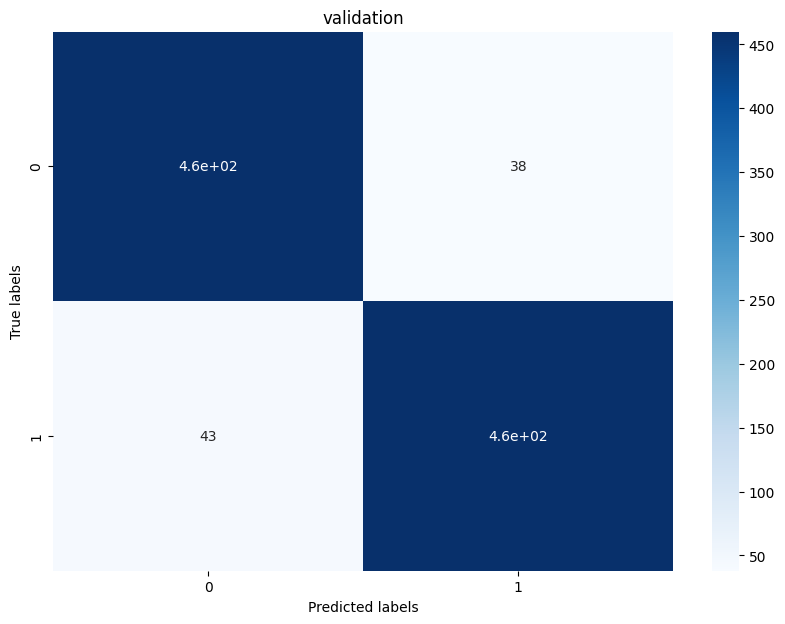

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy of the network on test images : 90%
F1-score of the network on test images : 0.8996960486322189
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       505
           1       0.90      0.90      0.90       495

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



<ipython-input-14-eac418f02df1>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  groundtruth = torch.tensor(groundtruth[:,1], dtype=torch.int)
<ipython-input-14-eac418f02df1>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicts = torch.tensor(predicts[:], dtype=torch.int)


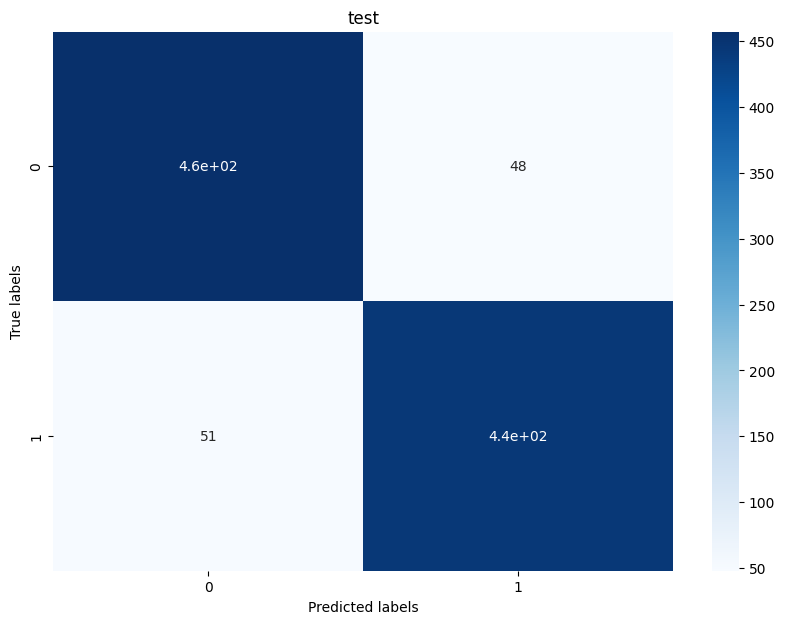

In [15]:
f1_score_eval(val_dataloader, 'validation')
f1_score_eval(test_dataloader, 'test')

In [ ]:
# can be used to reduce the GPU allocation memory
torch.cuda.empty_cache()
!nvidia-smi -caa
!nvidia-smi

Cleared Accounted PIDs for GPU 00000000:00:04.0.
All done.
Thu Sep  7 15:38:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    32W /  70W |   2265MiB / 15360MiB |     40%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                             